<a href="https://colab.research.google.com/github/abhipise2704/Human_Activity_Recognition/blob/master/HAR_LSTM_colab22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 21
## LSTM ON HUMAN ACTIVITY RECOGNITION
## abhipise2704@gmail.com_21

# 1: DATA UPLOADING /DATA PREPROCESSING 

### 1.1 Loading Folder HAR on  google drive 

In [0]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
#https://medium.com/@master_yi/importing-datasets-in-google-colab-c816fc654f97
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
#https://medium.com/@master_yi/importing-datasets-in-google-colab-c816fc654f97
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=118toouH8ifByKJHmmowyjOjGyir-YAvi'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('HumanActivityRecognition.zip')  
#data = pd.read_csv('preprocessed_data')
# Dataset is now stored in a Pandas Dataframe
#data.shape

118toouH8ifByKJHmmowyjOjGyir-YAvi


In [0]:
import zipfile


zip_ref = zipfile.ZipFile("/content/HumanActivityRecognition.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

### 1.2 Importing Library 

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### 1.4 Data Reading to Xtrain Xtest y_train and y_test

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        df=_read_csv(filename)
        df=df.values
        signals_data.append(np.asmatrix(df))

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y=pd.get_dummies(y)
    y=y.values
    #y=np.asmatrix(y)
    

    return y

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [0]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.get_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# 2 Defining the Architecture of LSTM(model 1)

### 2.1 Initialize Model

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


### 2.2 Model Compilation & Evaluation 

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 96s 13ms/step - loss: 1.3178 - accuracy: 0.4506 - val_loss: 1.1267 - val_accuracy: 0.5151
Epoch 2/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.9312 - accuracy: 0.6034 - val_loss: 0.8452 - val_accuracy: 0.6121
Epoch 3/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.7748 - accuracy: 0.6434 - val_loss: 0.7749 - val_accuracy: 0.6125
Epoch 4/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.7149 - accuracy: 0.6604 - val_loss: 0.7583 - val_accuracy: 0.5993
Epoch 5/30
7352/7352 [==============================] - 98s 13ms/step - loss: 0.6708 - accuracy: 0.6800 - val_loss: 1.0034 - val_accuracy: 0.6295
Epoch 6/30
7352/7352 [==============================] - 99s 13ms/step - loss: 0.6183 - accuracy: 0.7199 - val_loss: 0.6839 - val_accuracy: 0.7448
Epoch 7/30
7352/7352 [==============================] - 97s 13ms/step - loss

### 2.4 Confusion Matrix on Test Data for Model 1 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [0]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

# 3 LSTM model 2 

### 3.1 GridSearchCV for droprOut and LSTM units 


##### 3.1.1 Model Function  

In [0]:
#https://github.com/krishnaik06/Hidden-Layers-Neurons/blob/master/How%20to%20Select%20how%20many%20hidden%20layer%20and%20neurons%20in%20a%20neural%20network.ipynb
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
from keras.layers import BatchNormalization


def create_model(lstm_units_1,lstm_units_2,dropout_1,dropout_2):
    # create model
    model = Sequential()
    
    model.add(LSTM(lstm_units_1,return_sequences=True,
                   input_shape=(timesteps, input_dim)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_1))
    
    model.add(LSTM(lstm_units_2))
    model.add(Dropout(dropout_2))
    
    model.add(Dense(n_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model


### 3.2 GridSearchCV to Hyperparametr tuning 

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model, verbose=10)

In [0]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

lstm_units_1_list=[140,160]
lstm_units_2_list=[80,120]
dropout_1_list=[0.1,0.2,0.3]
dropout_2_list=[0.4,0.5,0.6]
#kernel_ini_list=['random_uniform','glorot_normal']
param_grid_dict = dict(lstm_units_1=lstm_units_1_list, 
                  lstm_units_2=lstm_units_2_list,
                  dropout_1 = dropout_1_list,
                  dropout_2=dropout_2_list)

grid = GridSearchCV( estimator=model,param_grid=param_grid_dict,verbose=10,cv=3)

In [74]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

grid_result = grid.fit(X_train,Y_train,epochs=2, batch_size=500)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=80 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=80, score=0.168, total=  12.4s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=80 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=80, score=0.293, total=  12.9s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=80 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.3s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=80, score=0.294, total=  12.6s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=120 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.9s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=120, score=0.168, total=  12.5s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=120 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.4s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=120, score=0.293, total=  12.8s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=120 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=140, lstm_units_2=120, score=0.324, total=  13.2s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=80 .


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=80, score=0.169, total=  12.7s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=80 .


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=80, score=0.277, total=  12.7s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=80 .


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=80, score=0.182, total=  12.6s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=120 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.9min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=120, score=0.233, total=  13.1s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=120 
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=120, score=0.315, total=  12.9s
[CV] dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=120 
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.4, lstm_units_1=160, lstm_units_2=120, score=0.312, total=  12.7s
[CV] dropout_1=0.1, dropout_2=0.5, lstm_units_1=140, lstm_units_2=80 .
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.5, lstm_units_1=140, lstm_units_2=80, score=0.234, total=  12.6s
[CV] dropout_1=0.1, dropout_2=0.5, lstm_units_1=140, lstm_units_2=80 .
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0.5, lstm_units_1=140, lstm_units_2=80, score=0.308, total=  13.2s
[CV] dropout_1=0.1, dropout_2=0.5, lstm_units_1=140, lstm_units_2=80 .
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.1, dropout_2=0

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 24.2min finished


Epoch 1/2
Epoch 2/2
Best: 0.329707 using {'dropout_1': 0.2, 'dropout_2': 0.4, 'lstm_units_1': 140, 'lstm_units_2': 80}
0.251774 (0.059173) with: {'dropout_1': 0.1, 'dropout_2': 0.4, 'lstm_units_1': 140, 'lstm_units_2': 80}
0.261570 (0.067592) with: {'dropout_1': 0.1, 'dropout_2': 0.4, 'lstm_units_1': 140, 'lstm_units_2': 120}
0.209055 (0.048095) with: {'dropout_1': 0.1, 'dropout_2': 0.4, 'lstm_units_1': 160, 'lstm_units_2': 80}
0.286456 (0.038133) with: {'dropout_1': 0.1, 'dropout_2': 0.4, 'lstm_units_1': 160, 'lstm_units_2': 120}
0.284144 (0.035344) with: {'dropout_1': 0.1, 'dropout_2': 0.5, 'lstm_units_1': 140, 'lstm_units_2': 80}
0.240203 (0.018454) with: {'dropout_1': 0.1, 'dropout_2': 0.5, 'lstm_units_1': 140, 'lstm_units_2': 120}
0.270817 (0.032212) with: {'dropout_1': 0.1, 'dropout_2': 0.5, 'lstm_units_1': 160, 'lstm_units_2': 80}
0.218034 (0.037578) with: {'dropout_1': 0.1, 'dropout_2': 0.5, 'lstm_units_1': 160, 'lstm_units_2': 120}
0.272845 (0.033137) with: {'dropout_1': 0.1, 

### 3.4 Best Hyperparameter for 2 Layered LSTM

In [75]:
print("="*80)
print("Best_Hyperparamaeter_LSTM::")
print("-"*80)
print(grid_result.best_params_)
print("="*80)

Best_Hyperparamaeter_LSTM::
--------------------------------------------------------------------------------
{'dropout_1': 0.2, 'dropout_2': 0.4, 'lstm_units_1': 140, 'lstm_units_2': 80}


## 3.5 Best LSTM model with Best Hyperparameter 

In [0]:
tf.keras.backend.clear_session()

In [78]:
# Importing libraries
#https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.regularizers import L1L2
from keras.layers import BatchNormalization


model_best = Sequential()
#reg = L1L2(0.01, 0.01)    

model_best.add(LSTM(140,return_sequences=True,
                    input_shape=(timesteps, input_dim),
                   ))
model_best.add(Dropout(0.2))
    
model_best.add(LSTM(80))
model_best.add(Dropout(0.4))
    
model_best.add(Dense(n_classes,  activation='sigmoid'))
    
model_best.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 140)          84000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 140)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                70720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 155,206
Trainable params: 155,206
Non-trainable params: 0
_________________________________________________________________


## 3.6 Compilation & Model_best Evaluation On Test Data

In [0]:
from keras.metrics import categorical_accuracy
# Compiling the model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop

opt=RMSprop()
model_best.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
print(K.eval(model_best.optimizer.lr))

1e-04


In [80]:

##https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


# Training the model
model_best.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),
          epochs=30,
          #callbacks=[checkpoint_3]
          )

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 91s 12ms/step - loss: 1.1114 - accuracy: 0.5224 - val_loss: 0.9161 - val_accuracy: 0.6634
Epoch 2/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.7161 - accuracy: 0.6933 - val_loss: 0.7694 - val_accuracy: 0.7038
Epoch 3/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.5643 - accuracy: 0.7542 - val_loss: 0.5115 - val_accuracy: 0.7754
Epoch 4/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.3286 - accuracy: 0.8802 - val_loss: 0.3644 - val_accuracy: 0.8853
Epoch 5/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.2218 - accuracy: 0.9256 - val_loss: 0.4902 - val_accuracy: 0.8765
Epoch 6/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.1768 - accuracy: 0.9374 - val_loss: 0.5044 - val_accuracy: 0.8554
Epoch 7/30
7352/7352 [==============================] - 90s 12ms/step - loss

 ## 3.7 Accuracy (Training & Validation) vs No of Epoch

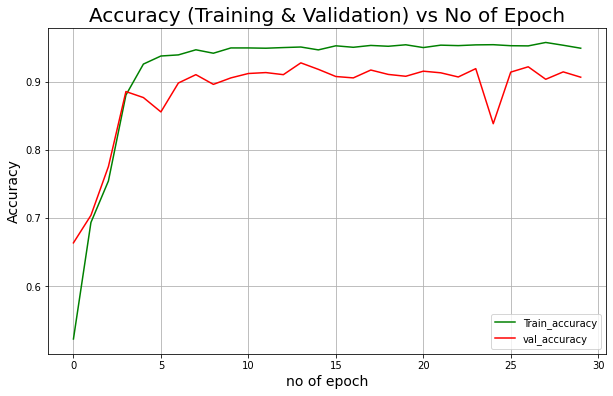

In [81]:
import pandas as pd
import numpy as np
losses = pd.DataFrame(model_best.history.history)

losses.head(2)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))

plt.plot(losses['accuracy'],color='green',label='Train_accuracy')
plt.plot(losses['val_accuracy'],color='red',label='val_accuracy')
plt.xlabel('no of epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy (Training & Validation) vs No of Epoch',fontsize=20)
plt.legend()
plt.grid()

## 3.8 Confusion Matrix on test data of LSTM 

In [82]:
# Confusion Matrix
cm_best=confusion_matrix(Y_test, model_best.predict(X_test))

print(confusion_matrix(Y_test, model_best.predict(X_test)))

import seaborn as sns
plt.figure(figsize=(17,9))
sns.heatmap(cm_best/np.sum(cm_best),annot=True,fmt='.2%',cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix of LSTM of Human Activity Recognition',fontsize=22)
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)

ValueError: ignored

In [0]:
score = model_best.evaluate(X_test, Y_test)

In [0]:
score

**OBESERVATION:**

1.   With 2 layered LSTM with different dropout rates we get 97.16% accuracy

2.   LSTM units for 1st Layer=100||
LSTM units for 2nd Layer=50 ||
DropOut_1=0.8 ||
DropOut_1=0.9 ||






# 4 DIVIDE & CONQUER APPROACH

**They refer to this as a two-stage modeling approach.
Instead of straightforwardly recognizing the individual activities using a single 6-class classifier, we apply a divide and conquer approach and build a two-stage activity recognition process, where abstract activities, i.e., dynamic and static activity, are first recognized using a 2-class or binary classifier, and then individual activities are recognized using two 3-class classifiers.**

— Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening, 2018.

https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/

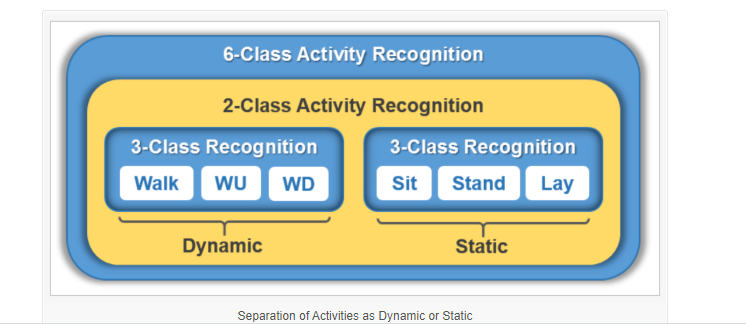

## 4.1 Divide problem into Binary Class Classification Problem

### 4.1.1 Function to load as Static Activity and Dynamic Activity 

In [0]:
from keras import backend as K 
K.clear_session()

In [0]:
#https://github.com/rohitgurjar058/Human-Activity-Recognition/blob/master/HAR_Deep_Learning_notebook.ipynb

def load_y_binary_static_dynamic(subset):
  
    """
    This function is to convert 6 class classification into 
    into binary class problem, First Static Activity and 
    Other is Dyanmic Activity 
    """  

    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
  
    y[y<=3] = 0
    y[y>3] = 1
  
    return pd.get_dummies(y).values

In [0]:
X_train_binary, X_test_binary = load_signals('train'), load_signals('test')
Y_train_binary, Y_test_binary = load_y_binary_static_dynamic('train'), load_y_binary_static_dynamic('test')

In [104]:
print("-"*50)
print("Shape of matrix Y_train_binary: ",Y_train_binary.shape)
print("Shape of matrix Y_test_binary: ",Y_test_binary.shape)
print("-"*50)
print("Shape of matrix X_train_binary: ",X_train_binary.shape)
print("Shape of matrix X_test_binary: ",X_test_binary.shape)
print("-"*50)

--------------------------------------------------
Shape of matrix Y_train_binary:  (7352, 2)
Shape of matrix Y_test_binary:  (2947, 2)
--------------------------------------------------
Shape of matrix X_train_binary:  (7352, 128, 9)
Shape of matrix X_test_binary:  (2947, 128, 9)
--------------------------------------------------


### 4.1.2 Timesteps Input Dim and n_classes

In [105]:
timesteps_binary = len(X_train_binary[0])
input_dim_binary = len(X_train_binary[0][0])
n_classes_binary = _count_classes(Y_train_binary)
print(timesteps_binary)
print(input_dim_binary)
print(n_classes_binary)


128
9
2


### 4.1.3 Model Lstm to Classify Static or Dynamic Activity (Binary Classification)

In [106]:
# Importing libraries
#https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.regularizers import L1L2
from keras.layers import BatchNormalization


model_binary_class = Sequential()
#reg = L1L2(0.01, 0.01)    

model_binary_class.add(LSTM(160,return_sequences=True,
                    input_shape=(timesteps_binary, input_dim_binary),
                   ))
model_binary_class.add(Dropout(0.2))
    
model_binary_class.add(LSTM(90))
model_binary_class.add(Dropout(0.6))
    
model_binary_class.add(Dense(n_classes_binary,  activation='sigmoid'))
    
model_binary_class.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 160)          108800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 160)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90)                90360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 182       
Total params: 199,342
Trainable params: 199,342
Non-trainable params: 0
_________________________________________________________________


### 4.1.4 Model Compilation & Evaluation (binary Classification)

In [107]:
#import math
#adam = keras.optimizers.Adam(lr=0.001)

model_binary_class.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_binary_class.fit(X_train_binary,Y_train_binary, 
                       epochs=10, 
                       batch_size=48,
                       validation_data=(X_test_binary, Y_test_binary),
                       verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 65s 9ms/step - loss: 0.2525 - accuracy: 0.8806 - val_loss: 0.0371 - val_accuracy: 0.9915
Epoch 2/10
7352/7352 [==============================] - 65s 9ms/step - loss: 0.0645 - accuracy: 0.9872 - val_loss: 0.1753 - val_accuracy: 0.9674
Epoch 3/10
7352/7352 [==============================] - 64s 9ms/step - loss: 0.4210 - accuracy: 0.8050 - val_loss: 0.5708 - val_accuracy: 0.6766
Epoch 4/10
7352/7352 [==============================] - 63s 9ms/step - loss: 0.4614 - accuracy: 0.7141 - val_loss: 0.4054 - val_accuracy: 0.8358
Epoch 5/10
7352/7352 [==============================] - 64s 9ms/step - loss: 0.4457 - accuracy: 0.7198 - val_loss: 0.4632 - val_accuracy: 0.6902
Epoch 6/10
7352/7352 [==============================] - 63s 9ms/step - loss: 0.3280 - accuracy: 0.8161 - val_loss: 0.3218 - val_accuracy: 0.9209
Epoch 7/10
7352/7352 [==============================] - 63s 9ms/step - loss: 0.072

### 4.1.5 Accuracy of Binary Classification model 

In [108]:
accuracy_train = model_binary_class.evaluate(X_train_binary,Y_train_binary,verbose=0)
accuracy_val = model_binary_class.evaluate(X_test_binary,Y_test_binary,verbose=0)

print('Train_accuracy on Binary Problem:',accuracy_train,'\ntest_accuracy on Binary Problem:',accuracy_val)

Train_accuracy on Binary Problem: [0.0075847771210277755, 0.998775839805603] 
test_accuracy on Binary Problem: [0.035271932739286624, 0.9925347566604614]


### 4.1.6 Saving Model Binary Classification 


In [0]:
model_binary_class.save('model_binary_class_save.h5')
model_file = drive.CreateFile({'model_binary_class' : 'model_binary_class_save.h5'}) 
model_file.SetContentFile('model_binary_class_save.h5')
model_file.Upload()

In [114]:
# download to google drive                       
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '109GPv64cAOvPpKg8kfpmx2HD2PqIiGKy'})

## 4.2 Classify_static_activities ,Static 3 Class Classification Problem 

### 4.2.1 Functions to load Static Acitivity 

In [0]:
from keras import backend as K 
K.clear_session()

In [0]:
def load_y_static(subset):
  
    """
    This Function is get static activity sorted
    """
  
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
  
    y_true = y>3
    y = y[y>3]
  
    return pd.get_dummies(y).values, y_true

In [0]:
X_train_static, X_test_static = load_signals('train'), load_signals('test')
Y_train_static, y_train_true = load_y_static('train')
Y_test_static, y_test_true   = load_y_static('test')
X_train_static = X_train_static[y_train_true]
X_test_static = X_test_static[y_test_true]

In [75]:
print("-"*50)
print("Shape of matrix Y_train_static: ",Y_train_static.shape)
print("Shape of matrix Y_test_static: ",Y_test_static.shape)
print("-"*50)
print("Shape of matrix X_train_static: ",X_train_static.shape)
print("Shape of matrix X_test_static: ",X_test_static.shape)
print("-"*50)

--------------------------------------------------
Shape of matrix Y_train_static:  (4067, 3)
Shape of matrix Y_test_static:  (1560, 3)
--------------------------------------------------
Shape of matrix X_train_static:  (4067, 128, 9)
Shape of matrix X_test_static:  (1560, 128, 9)
--------------------------------------------------


### 4.2.2 Timesteps Input Dim and n_classes

In [76]:
timesteps_static = len(X_train_static[0])
input_dim_static = len(X_train_static[0][0])
n_classes_static = _count_classes(Y_train_static)
print(timesteps_static)
print(input_dim_static)
print(n_classes_static)


128
9
3


### 4.2.3 Model CNN to Classify Static  Activity (3 Class Classification)

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

In [78]:
#https://www.mdpi.com/1424-8220/18/4/1055
#https://github.com/rohitgurjar058/Human-Activity-Recognition/blob/master/HAR_Deep_Learning_notebook.ipynb

model_static = Sequential()
# Configuring the parameters
model_static.add(Conv1D(filters = 561, kernel_size=3,
                 activation='relu',padding = 'same',
                 input_shape = (timesteps_static,input_dim_static)))
model_static.add(MaxPooling1D(pool_size=2))

model_static.add(Conv1D(filters = 559, kernel_size=2,
                 activation='sigmoid',padding = 'same'))
model_static.add(MaxPooling1D(pool_size=3))
model_static.add(BatchNormalization())

model_static.add(Conv1D(filters = 557, kernel_size=4,
             activation='sigmoid',padding = 'same'))
model_static.add(BatchNormalization())
model_static.add(Dropout(0.9))

model_static.add(Conv1D(filters = 555, kernel_size=2,
             activation='sigmoid',padding = 'same'))
model_static.add(Dropout(0.5))

model_static.add(Flatten())

model_static.add(Dense(1024, activation='sigmoid'))
model_static.add(Dropout(0.7))

model_static.add(Dense(512, activation='sigmoid'))
model_static.add(Dropout(0.5))

model_static.add(Dense(64, activation='sigmoid'))
model_static.add(Dropout(0.4))

# Adding a dense output layer with sigmoid activation
model_static.add(Dense(n_classes_static, activation='softmax'))

model_static.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 561)          15708     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 561)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 559)           627757    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 559)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 559)           2236      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 557)           1246009   
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 557)          

### 4.2.4 Model Compilation & Evaluation (Static 3 Class Classification)

In [79]:
adam = keras.optimizers.Adam(lr=10**-4)
model_static.compile(loss='categorical_crossentropy',
                     metrics=['accuracy'], 
                     optimizer=adam)

model_static.fit(X_train_static,Y_train_static, 
                epochs=130, 
                batch_size=32,
                validation_data=(X_test_static, Y_test_static),
                verbose=1)

Train on 4067 samples, validate on 1560 samples
Epoch 1/130
4067/4067 [==============================] - 3s 758us/step - loss: 0.9802 - accuracy: 0.5124 - val_loss: 1.1493 - val_accuracy: 0.3410
Epoch 2/130
4067/4067 [==============================] - 2s 577us/step - loss: 0.5969 - accuracy: 0.6749 - val_loss: 0.7883 - val_accuracy: 0.5756
Epoch 3/130
4067/4067 [==============================] - 2s 595us/step - loss: 0.4599 - accuracy: 0.7846 - val_loss: 0.3761 - val_accuracy: 0.8481
Epoch 4/130
4067/4067 [==============================] - 2s 574us/step - loss: 0.3171 - accuracy: 0.9058 - val_loss: 0.3225 - val_accuracy: 0.8744
Epoch 5/130
4067/4067 [==============================] - 2s 578us/step - loss: 0.2827 - accuracy: 0.9083 - val_loss: 0.3156 - val_accuracy: 0.8897
Epoch 6/130
4067/4067 [==============================] - 2s 569us/step - loss: 0.2671 - accuracy: 0.9044 - val_loss: 0.3066 - val_accuracy: 0.8865
Epoch 7/130
4067/4067 [==============================] - 2s 589us/step

### 4.2.5 Accuracy of static 3 classs Classification model 

In [80]:
accuracy_train = model_static.evaluate(X_train_static,Y_train_static,verbose=0)
accuracy_val = model_static.evaluate(X_test_static,Y_test_static,verbose=0)

print('Train_accuracy on 3 classification static Problem:',
      accuracy_train,'\ntest_accuracy on 3 classification static Problem:',accuracy_val)

Train_accuracy on 3 classification static Problem: [0.021264021563142933, 0.991640031337738] 
test_accuracy on 3 classification static Problem: [0.2770053438121417, 0.9403846263885498]


### 4.2.6 Accuracy vs Epoch for Train and Validation Graph model 3 Class 

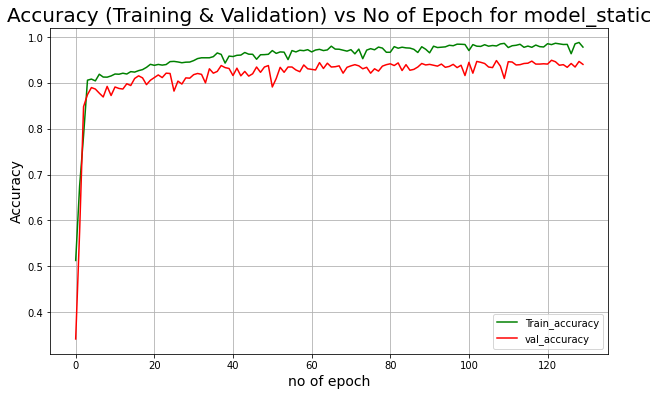

In [81]:
import pandas as pd
import numpy as np
losses = pd.DataFrame(model_static.history.history)

losses.head(2)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))

plt.plot(losses['accuracy'],color='green',label='Train_accuracy')
plt.plot(losses['val_accuracy'],color='red',label='val_accuracy')
plt.xlabel('no of epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy (Training & Validation) vs No of Epoch for model_static',fontsize=20)
plt.legend()
plt.grid()

### 4.2.7 Model Static Saving 

In [0]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
#https://medium.com/@master_yi/importing-datasets-in-google-colab-c816fc654f97
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#!pip install httplib2==0.15.0

In [0]:
model_static.save('model_static_save_CNN.h5')
model_file = drive.CreateFile({'model_static_save_CNN' : 'model_static_save_CNN.h5'}) 
model_file.SetContentFile('model_static_save_CNN.h5')
model_file.Upload()

### 4.2.8 Model Static Confusion Matrix 

In [0]:
#https://github.com/scikit-learn/scikit-learn/issues/12700
#https://github.com/rohitgurjar058/Human-Activity-Recognition/blob/master/HAR_Deep_Learning_notebook.ipynb
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt
ACTIVITIES = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix_divide_conquer(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

In [86]:
print(confusion_matrix_divide_conquer(Y_test_static, model_static.predict(X_test_static)))

[[537   0   0]
 [  1 409  81]
 [  0  11 521]]


In [0]:
cm_static=confusion_matrix_divide_conquer(Y_test_static, model_static.predict(X_test_static))

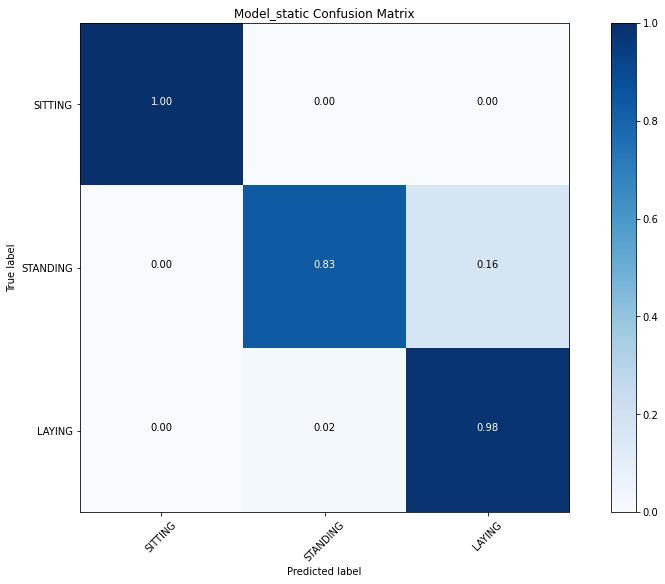

In [88]:
from sklearn.metrics import classification_report,confusion_matrix

#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import seaborn as sns
plt.figure(figsize=(15,9))
cm_static = confusion_matrix_divide_conquer(Y_test_static, model_static.predict(X_test_static))
plot_confusion_matrix(cm_static, classes=['SITTING','STANDING','LAYING'], normalize=True, title='Model_static Confusion Matrix', cmap = plt.cm.Blues)
plt.show()


## 4.3 Classify_dynamic_activities ,Dynmaic 3 Class Classification Problem 

### 4.3.1 Functions to load Dynamic Acitivity 

In [0]:
def load_y_dynamic(subset):
  
    """
    This function separates dyanmaic activity from static activity to 
    convert the problem into 3 class classification for Dynamic Activity 
    """
  
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
  
    y_true = y<=3
    y = y[y<=3]
  
    return pd.get_dummies(y).values, y_true

In [0]:
X_train_dynamic, X_test_dynamic = load_signals('train'), load_signals('test')

Y_train_dynamic, y_train_true = load_y_dynamic('train')
Y_test_dynamic, y_test_true    = load_y_dynamic('test')

X_train_dynamic = X_train_dynamic[y_train_true]
X_test_dynamic = X_test_dynamic[y_test_true]

In [21]:
print("-"*50)
print("Shape of matrix Y_train_dynamic: ",Y_train_dynamic.shape)
print("Shape of matrix Y_test_dynamic: ",Y_test_dynamic.shape)
print("-"*50)
print("Shape of matrix X_train_dynamic: ",X_train_dynamic.shape)
print("Shape of matrix X_test_dynamic: ",X_test_dynamic.shape)
print("-"*50)

--------------------------------------------------
Shape of matrix Y_train_dynamic:  (3285, 3)
Shape of matrix Y_test_dynamic:  (1387, 3)
--------------------------------------------------
Shape of matrix X_train_dynamic:  (3285, 128, 9)
Shape of matrix X_test_dynamic:  (1387, 128, 9)
--------------------------------------------------


### 4.3.2 Timesteps Input Dim and n_classes

In [22]:
timesteps_dynamic = len(X_train_dynamic[0])
input_dim_dynamic = len(X_train_dynamic[0][0])
n_classes_dynamic = _count_classes(Y_train_dynamic)
print(timesteps_dynamic)
print(input_dim_dynamic)
print(n_classes_dynamic)


128
9
3


### 4.3.3 Model CNN to Classifiy Dynamic Activites

In [0]:
from keras import backend as K 
K.clear_session()

In [40]:
##https://github.com/xSachinBharadwajx/Human-Activity-Recognition-Using-Smartphones-DivideAndConquer

model_dynamic = Sequential()
model_dynamic.add(Conv1D(filters=64, kernel_size=3,padding='same', 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     input_shape=(128,9)))

model_dynamic.add(Conv1D(filters=32, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(Dropout(0.6))
model_dynamic.add(MaxPooling1D(pool_size=1,strides=1))

model_dynamic.add(Flatten())
model_dynamic.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(BatchNormalization()) 
model_dynamic.add(Dropout(0.6))

model_dynamic.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(BatchNormalization()) 
model_dynamic.add(Dropout(0.6))

model_dynamic.add(Dense(3, activation='softmax'))

model_dynamic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 64)           1792      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           10272     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                262208    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

### 4.3.4 Model Compilation & Evaluation (Dynamic 3 Class Classification)

In [41]:
#import math
adam = keras.optimizers.Adam(lr=0.0001)

model_dynamic.compile(loss='categorical_crossentropy',
                           optimizer='adam', 
                           metrics=['accuracy'])

model_dynamic.fit(X_train_dynamic,Y_train_dynamic, 
                epochs=120, 
                batch_size=32,
                validation_data=(X_test_dynamic, Y_test_dynamic),
                verbose=1)

Train on 3285 samples, validate on 1387 samples
Epoch 1/120
3285/3285 [==============================] - 1s 403us/step - loss: 1.7770 - accuracy: 0.3851 - val_loss: 1.3870 - val_accuracy: 0.3735
Epoch 2/120
3285/3285 [==============================] - 1s 216us/step - loss: 1.2439 - accuracy: 0.4566 - val_loss: 1.0779 - val_accuracy: 0.5141
Epoch 3/120
3285/3285 [==============================] - 1s 229us/step - loss: 0.8944 - accuracy: 0.5836 - val_loss: 0.6159 - val_accuracy: 0.7267
Epoch 4/120
3285/3285 [==============================] - 1s 222us/step - loss: 0.5998 - accuracy: 0.7239 - val_loss: 0.4338 - val_accuracy: 0.8515
Epoch 5/120
3285/3285 [==============================] - 1s 218us/step - loss: 0.4234 - accuracy: 0.8311 - val_loss: 0.3083 - val_accuracy: 0.8882
Epoch 6/120
3285/3285 [==============================] - 1s 220us/step - loss: 0.3030 - accuracy: 0.8962 - val_loss: 0.2584 - val_accuracy: 0.9056
Epoch 7/120
3285/3285 [==============================] - 1s 212us/step

### 4.3.5 Accuracy on Dynamic Activities

In [42]:
accuracy_train = model_dynamic.evaluate(X_train_dynamic,Y_train_dynamic,verbose=0)
accuracy_val = model_dynamic.evaluate(X_test_dynamic,Y_test_dynamic,verbose=0)

print('Train_accuracy on 3 classification dynamic Problem:',
      accuracy_train,'\ntest_accuracy on 3 classification dynamic Problem:',accuracy_val)

Train_accuracy on 3 classification dynamic Problem: [1.8037837257979763e-07, 1.0] 
test_accuracy on 3 classification dynamic Problem: [0.11225277295033208, 0.9776496291160583]


### 4.3.6 Accuracy vs Epoch for Train and Validation Graph modelDynamic 3 Class 

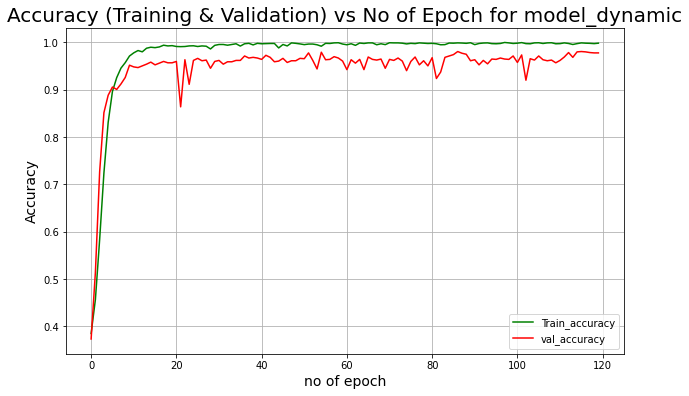

In [43]:
import pandas as pd
import numpy as np
losses = pd.DataFrame(model_dynamic.history.history)

losses.head(2)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))

plt.plot(losses['accuracy'],color='green',label='Train_accuracy')
plt.plot(losses['val_accuracy'],color='red',label='val_accuracy')
plt.xlabel('no of epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy (Training & Validation) vs No of Epoch for model_dynamic',fontsize=20)
plt.legend()
plt.grid()

In [0]:
model_dynamic.save('model_dynamic_save_CNN.h5')
model_file = drive.CreateFile({'model_dynamic_3class' : 'model_dynamic_save_CNN.h5'}) 
model_file.SetContentFile('model_dynamic_save_CNN.h5')
model_file.Upload()

In [0]:
#https://github.com/rohitgurjar058/Human-Activity-Recognition/blob/master/HAR_Deep_Learning_notebook.ipynb
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
}

# Utility function to print the confusion matrix
def confusion_matrix_divide_conquer(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

In [47]:
print(confusion_matrix_divide_conquer(Y_test_dynamic, model_dynamic.predict(X_test_dynamic)))

[[488   8   0]
 [  1 419   0]
 [  0  22 449]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


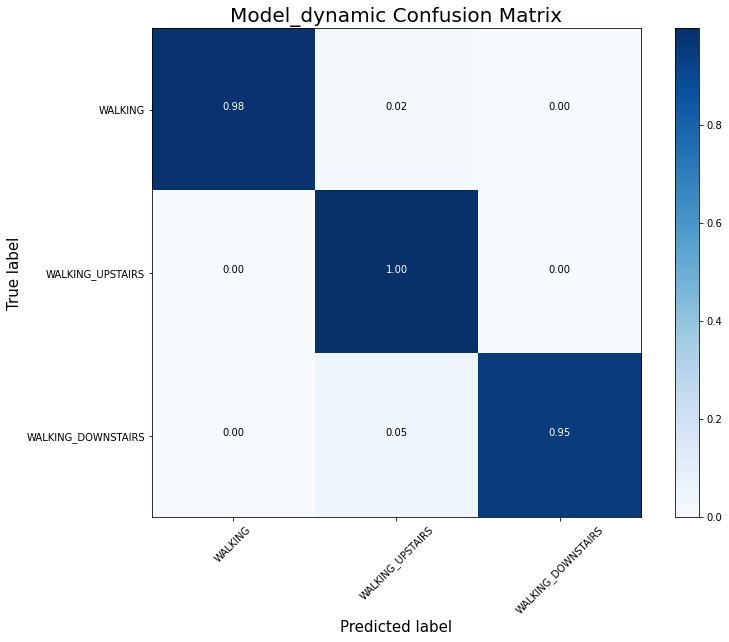

In [48]:
from sklearn.metrics import classification_report,confusion_matrix

#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import seaborn as sns
plt.figure(figsize=(12,9))
cm_dynamic=confusion_matrix_divide_conquer(Y_test_dynamic, model_dynamic.predict(X_test_dynamic))
plot_confusion_matrix(cm_dynamic, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'],
                      normalize=True, title='Model_dynamic Confusion Matrix', cmap = plt.cm.Blues)
plt.show()


## 4.4 Final Prediction 

In [0]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
#https://medium.com/@master_yi/importing-datasets-in-google-colab-c816fc654f97
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [50]:

link = 'https://drive.google.com/open?id=1lCSxTT2xiQ3HYIHVJImd0i2hoFrgpEWs'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('model_dynamic_save_CNN.h5')  
#data = pd.read_csv('preprocessed_data')
# Dataset is now stored in a Pandas Dataframe
#data.shape

1lCSxTT2xiQ3HYIHVJImd0i2hoFrgpEWs


In [51]:

link = 'https://drive.google.com/open?id=1J2dmOg7XVe9zAe_UdWSoOghESjGocbOD'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('model_static_save_CNN.h5')  
#data = pd.read_csv('preprocessed_data')
# Dataset is now stored in a Pandas Dataframe
#data.shape

1J2dmOg7XVe9zAe_UdWSoOghESjGocbOD


In [52]:
link = 'https://drive.google.com/open?id=109GPv64cAOvPpKg8kfpmx2HD2PqIiGKy'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('model_binary_class_save.h5')  
#data = pd.read_csv('preprocessed_data')
# Dataset is now stored in a Pandas Dataframe
#data.shape

109GPv64cAOvPpKg8kfpmx2HD2PqIiGKy


### 4.4.1 Load Models 

In [0]:
##loading keras models and picle files for scaling data 
from keras.models import load_model
import pickle
model_binary_class_save= load_model('model_binary_class_save.h5')
model_dynamic_save = load_model('model_dynamic_save_CNN.h5')
model_static_save = load_model('model_static_save_CNN.h5')

### 4.4.2 Final Prediction Function 

In [0]:
#https://github.com/rohitgurjar058/Human-Activity-Recognition/blob/master/HAR_Deep_Learning_notebook.ipynb

def final_prediction_function(X):

    """
    This Function Firstly Predict Static or Dynamic(Binary Classification)
    After classifying into static(3 Class classification) And Dynamic(3 Class 
    Classification) then it is classfied into 3 class claassification Problem.
    Function return final prediction
    """ 


    predict_static_dynamic = model_binary_class_save.predict(X)
    y_predict_static_dynamic =  np.argmax(predict_static_dynamic, axis=1)
  
    #static data,Data is divided into static or dynamic based on labels
    X_static = X[y_predict_static_dynamic==1]
    #dynamic data,Data is divided into static or dynamic based on labels
    X_dynamic = X[y_predict_static_dynamic==0]
  

    #predicting Static Activity 3 class classification 
    predict_static = model_static_save.predict(X_static)
    y_predict_static = np.argmax(predict_static,axis=1)
    y_predict_static_class_label = y_predict_static + 4

    #predicting Dynamic Activity 3 class classification 
    predict_dy = model_dynamic_save.predict(X_dynamic)
    predict_dynamic = np.argmax(predict_dy,axis=1)
    y_predict_dynamic_class_label = predict_dynamic + 1


    #for sequence of data the prediction is saved into list called as final Prediction
    i,j = 0,0 
    final_prediction = []
    for prediction in y_predict_static_dynamic:
        if prediction == 1:
          final_prediction.append(y_predict_static_class_label[i])
          i = i + 1
        else:
          final_prediction.append(y_predict_dynamic_class_label[j])
          j = j + 1 
      
    return final_prediction

In [0]:

#predicting final output on Trian and test
final_pred_test = final_prediction_function(X_test)
rounded_labels_test=np.argmax(final_pred_test)


final_pred_train = final_prediction_function(X_train)
rounded_labels_train=np.argmax(final_pred_train)


In [0]:
def load_y_final(subset):
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return y

### 4.4.3 Final Accuracy on Complete Data 

In [62]:
##accuracy of train and test
from sklearn.metrics import accuracy_score
print("="*50)
print('Accuracy of Train data:',accuracy_score(load_y_final('train'),final_pred_train))
print("-"*50)
print('Accuracy of Test data:',accuracy_score(load_y_final('test'),final_pred_test))
print("="*50)

Accuracy of Train data: 0.9941512513601741
--------------------------------------------------
Accuracy of Test data: 0.9511367492365117


### 4.4.4 Final Confusion Matrix

In [58]:

from sklearn.metrics import confusion_matrix
cm_final = confusion_matrix(load_y_final('test'), final_pred_test)
cm_final

array([[488,   0,   8,   0,   0,   0],
       [  0, 447,  22,   1,   1,   0],
       [  1,   0, 412,   0,   7,   0],
       [  2,   2,   0, 406,  80,   1],
       [  4,   3,   0,  10, 515,   0],
       [  0,   2,   0,   0,   0, 535]])

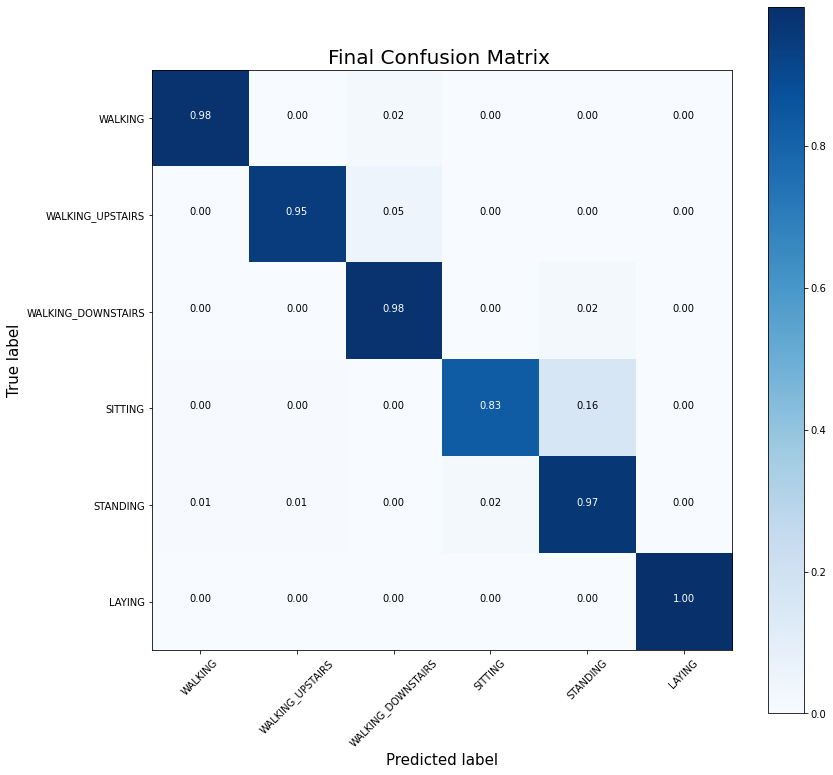

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,13))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
plot_confusion_matrix(cm_final, classes=labels, 
                      normalize=True, 
                      title='Final Confusion Matrix ',
                      cmap = plt.cm.Blues)
plt.show()

# 5 Conclusion 

In [0]:
#!/usr/bin/python3

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["MODEL", "FEATURIZATION","Accuracy"]

x.add_row(["Best_LR", "Feature_engineered_FFT","95.11%"])
x.add_row(["LSTM_1_layered", "Raw_time_series_data","90.03%"])
x.add_row(["LSTM_2_layered", "Raw_time_series_data","97.16%"])
x.add_row(["Divide & Conquer Approarch ", "Raw_time_series_data","95.11%"])


print(x)